In [1]:
import numpy as np
from learned_ctrlr_opt.systems.upkie.upkie import DelayedUpkieSystem, WheeledInvertedPendulumParams, MPCBalancerParams
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
%matplotlib inline

# Sweep Gains to Test their Effect

In [79]:
params = WheeledInvertedPendulumParams(leg_length=0.7, wheel_radius=0.06, action_lpf=0.0, mpc_sampling_period=0.1)
robot = DelayedUpkieSystem(params=params, time_horizon_s=2)

In [21]:
num_gains = 10
all_metrics = np.zeros((num_gains, num_gains, 3))
all_lengths = np.linspace(MPCBalancerParams.get_bounds()[0,0], MPCBalancerParams.get_bounds()[0,1], num_gains)
all_radii = np.linspace(MPCBalancerParams.get_bounds()[1,0], MPCBalancerParams.get_bounds()[1,1], num_gains)

for i in range(num_gains):
    for j in range(num_gains):
        gains = MPCBalancerParams(leg_length=all_lengths[i], wheel_radius=all_radii[j]).get_list()
        metrics, traj = robot.evaluate_gain(gains, init_state=np.array([0, 0.01, 0.0, 0.02]))
        all_metrics[i,j] = metrics

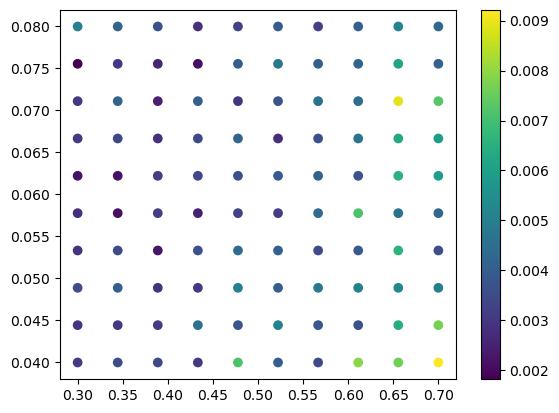

In [25]:
xx,yy = np.meshgrid([i for i in range(num_gains)], [i for i in range(num_gains)])
plt.scatter(all_lengths[xx.flatten()], all_radii[yy.flatten()], c=all_metrics[...,0].flatten())
plt.colorbar()

# Evaluate Upkie OCCAM Model

In [109]:
import matplotlib.pyplot as plt
import h5py
import torch.optim
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import DataLoader
from datetime import datetime
import os
from omegaconf import OmegaConf
import time

from learned_ctrlr_opt.utils.learning_utils import init_weights, create_network
from learned_ctrlr_opt.utils.experiment_utils import *
from learned_ctrlr_opt.meta_learning.lsr_net import *
from learned_ctrlr_opt.meta_learning.basis_kf import *
from learned_ctrlr_opt.meta_learning.utils import get_sysid_history_dataset, get_scalers
from learned_ctrlr_opt.opt.random_search import *

In [110]:
kf_checkpoint_dir = "model_checkpoints/upkie_mpc_lstsq_net/leafy-lion-645_Sep_27_2024/"

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

kf_cfg = OmegaConf.load(os.path.join(kf_checkpoint_dir, "config.yaml"))

# load scalers
scalers = get_scalers(kf_cfg.path_to_dataset, kf_cfg.history_length, kf_cfg.metric_idxs, kf_cfg.metric_idxs_to_invert)
gain_scaler = scalers[0]
metric_scaler = scalers[2]

gain_dim = len(kf_cfg.gains_to_optimize)
initial_state_dim = 4

kf_network = LSRBasisNet(in_size=gain_dim + initial_state_dim,
                         n_bases=kf_cfg.n_bases,
                         n_targets=len(kf_cfg.metric_idxs),
                         layer_sizes=kf_cfg.layer_sizes,
                         nonlin=kf_cfg.nonlin).float().train().to(device)


kf_network.load_state_dict(torch.load(os.path.join(kf_checkpoint_dir, "model_epoch_145.pt")))
kf_network.use_last_layer = False
kf_network = kf_network.eval().to(device)

dset_f = h5py.File(kf_cfg.path_to_dataset, 'r')
ref_tracks_enc = np.array(dset_f["reference_tracks_enc"])
ref_track_scaler = MinMaxScaler(clip=True).fit(ref_tracks_enc.reshape(-1, ref_tracks_enc.shape[-1]))
dset_f.close()

/tmp/ipykernel_727234/3018529769.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  kf_network.load_state_dict(torch.load(os.path.join(kf_checkpoint_dir, "model_epoch_145.

In [215]:
# params = WheeledInvertedPendulumParams(leg_length=0.4, wheel_radius=0.07, action_lpf=0.0, mpc_sampling_period=0.05)
# robot = DelayedUpkieSystem(params=params, time_horizon_s=1)

all_params = np.array([[0.5, 0.07, 0.0, 0.15],
                       [0.3, 0.04, 0.0, 0.1],
                       [0.7, 0.07, 0.1, 0.1],
                       [0.58, 0.06, 0.1, 0.1],
                      [0.8, 0.06, 0.0, 0.1],
                      [0.4, 0.04, 0.0, 0.07]])


num_trials = 30

initial_state_bounds = np.array([[0, 0],
                                 [-0.04, 0.04],
                                 [-0.15, 0.15],
                                 [-0.02, 0.02]])

cost_weights = np.array([-1, -0.0, -0.0])
init_state_fixed = denormalize(np.random.rand(4), initial_state_bounds)
gain_dim = 2
ep_length_s = 1

In [216]:
perf_metrics = np.zeros((all_params.shape[0], num_trials, 3))
actual_rwds = np.zeros((all_params.shape[0], num_trials))
expected_rwds = np.zeros((all_params.shape[0], num_trials))
tried_gains= np.zeros((all_params.shape[0], num_trials, 2))

for p in range(all_params.shape[0]):
    robot = DelayedUpkieSystem(params=WheeledInvertedPendulumParams(*all_params[p]), time_horizon_s=ep_length_s)
    weights = kf_network.last_layer_prior
    sigma = torch.mm(kf_network.last_layer_prior_cov_sqrt, torch.t(kf_network.last_layer_prior_cov_sqrt)).float().to(device)
    Q = torch.mm(kf_network.Q_sqrt, torch.t(kf_network.Q_sqrt)).float().to(device)
    R = torch.mm(kf_network.R_sqrt, torch.t(kf_network.R_sqrt)).float().to(device)
    
    full_traj = []
    
    task_input_data = torch.zeros(num_trials, gain_dim + initial_state_dim)
    task_target_data = torch.zeros(num_trials, len(kf_cfg.metric_idxs))
    
    init_state = init_state_fixed
    print(f"On Robot {p}")
    for i in range(num_trials):
        def eval_fn(x, cost_weights, sigma_weight):
            q = x.size(0)
            cost_weights = torch.from_numpy(cost_weights).float().to(device)
            ys, sigmas = last_layer_prediction_uncertainty_aware(x.float().to(device), kf_network, weights, sigma)
            cost_weights_batch = cost_weights.repeat(q).reshape((q, cost_weights.shape[-1])).to(device)
            mean_losses = torch.sum(ys * cost_weights_batch, dim=-1)
            variances = torch.zeros(x.size(0)).to(device)
            for j in range(x.size(0)):
                inter = torch.mm(sigmas[j], cost_weights.unsqueeze(-1))
                variances[j] = torch.mm(torch.t(cost_weights.unsqueeze(-1)), inter)
            losses = mean_losses + sigma_weight * variances
            return losses, ys, variances
    
        init_state_enc = torch.from_numpy(ref_track_scaler.transform(init_state.reshape(1, -1))).float().squeeze()
        
        if i > 0:
            perturbed_optima = [task_input_data[:i,:gain_dim]]
            for num_to_add in range(10):
                noisy_task_input_data = torch.clip(task_input_data[:i,:gain_dim] + torch.randn(task_input_data[:i,:gain_dim].shape) * 3e-2, 0, 1)
                perturbed_optima.append(noisy_task_input_data)
            both_task_input_data = torch.cat(perturbed_optima, dim=0)
        else:
            both_task_input_data = task_input_data[:i,:gain_dim]

        results = random_search(eval_fn,
                                2048,
                                cost_weights,
                                gain_dim,
                                device,
                                init_state_enc,
                                batch_size=2048,
                                sigma_weight=0.0,
                                guaranteed_searches=both_task_input_data)
        best_gain = results[0]
        best_y = results[2]
        best_gain_unscaled = np.squeeze(gain_scaler.inverse_transform(best_gain.unsqueeze(0).detach().cpu().numpy()))
        metrics, traj = robot.evaluate_gain(best_gain_unscaled, init_state=init_state)
        for t in range(traj.shape[0]):
            full_traj.append(traj[t])
        
        metrics_scaled = np.squeeze(metric_scaler.transform(np.expand_dims(metrics, 0)))
        actual_rwd = np.dot(cost_weights, metrics_scaled)
        # print(f"step {i}: actual rwd = {actual_rwd}")
        # print(f"step {i}: expected rwd = {best_y}")
        # print(f"step {i}: best gain = {best_gain_unscaled}")
        # print(f"step {i}: metrics = {metrics}")
        # print("------------------------")
        
        perf_metrics[p][i] = metrics
        actual_rwds[p][i] = actual_rwd
        expected_rwds[p][i] = best_y
    
        if not np.any(traj[-1]):
            print("resetting!")
            init_state = init_state_fixed
        else:
            init_state = traj[-1]
        task_input_data[i] = torch.cat([best_gain, init_state_enc], dim=-1)
        task_target_data = torch.from_numpy(metrics_scaled).float().squeeze()
        
        phi = kf_network(torch.cat([best_gain, init_state_enc], dim=-1).float().to(device).unsqueeze(0)).squeeze()
        target = torch.from_numpy(metrics_scaled).float().to(device).squeeze()
        with torch.no_grad():
            weights, sigma, K = kalman_step(weights, sigma, target.float().to(device), phi, Q, R)

On Robot 0
On Robot 1
On Robot 2
On Robot 3
On Robot 4
On Robot 5


# Nominal Gains Only

In [217]:
perf_metrics_nom = np.zeros((all_params.shape[0], num_trials, 3))
actual_rwds_nom = np.zeros((all_params.shape[0], num_trials)) 
full_traj_nom = []
for p in range(all_params.shape[0]):
    init_state = init_state_fixed
    robot = DelayedUpkieSystem(WheeledInvertedPendulumParams(*all_params[p]), time_horizon_s=ep_length_s)
    print(f"On Robot {p}")
    for i in range(num_trials):
        best_gain_unscaled = MPCBalancerParams().get_list()
        metrics, traj = robot.evaluate_gain(best_gain_unscaled, init_state=init_state)
        for t in range(traj.shape[0]):
            full_traj_nom.append(traj[t])
        
        metrics_scaled = np.squeeze(metric_scaler.transform(np.expand_dims(metrics, 0)))
        actual_rwd = np.dot(cost_weights, metrics_scaled)
        # print(f"step {i}: actual cost = {actual_rwd}")
        # print(f"step {i}: metrics = {metrics}")
        # print("------------------------")
        
        perf_metrics_nom[p][i] = metrics
        actual_rwds_nom[p][i] = actual_rwd
    
        if not np.any(traj[-1]):
            print("resetting!")
            init_state = init_state_fixed
        else:
            init_state = traj[-1]


On Robot 0
On Robot 1
terminated!
resetting!
On Robot 2
On Robot 3
terminated!
resetting!
terminated!
resetting!
terminated!
resetting!
On Robot 4
On Robot 5


# "Ground Truth" Correct Gains

In [218]:
perf_metrics_gt = np.zeros((all_params.shape[0], num_trials, 3))
actual_rwds_gt = np.zeros((all_params.shape[0], num_trials)) 
full_traj_gt = []
for p in range(all_params.shape[0]):
    init_state = init_state_fixed
    robot = DelayedUpkieSystem(WheeledInvertedPendulumParams(*all_params[p]), time_horizon_s=ep_length_s)
    print(f"On Robot {p}")
    for i in range(num_trials):
        best_gain_unscaled = MPCBalancerParams(leg_length=all_params[p][0], wheel_radius=all_params[p][1]).get_list()
        try:
            metrics, traj = robot.evaluate_gain(best_gain_unscaled, init_state=init_state)
        except TypeError:
            break
        for t in range(traj.shape[0]):
            full_traj_nom.append(traj[t])
        
        metrics_scaled = np.squeeze(metric_scaler.transform(np.expand_dims(metrics, 0)))
        actual_rwd = np.dot(cost_weights, metrics_scaled)
        # print(f"step {i}: actual cost = {actual_rwd}")
        # print(f"step {i}: metrics = {metrics}")
        # print("------------------------")
        
        perf_metrics_gt[p][i] = metrics
        actual_rwds_gt[p][i] = actual_rwd
    
        if not np.any(traj[-1]):
            print("resetting!")
            init_state = init_state_fixed
        else:
            init_state = traj[-1]


On Robot 0
On Robot 1
On Robot 2
On Robot 3
On Robot 4
On Robot 5


Text(0, 0.5, 'Reward Obtained in Last Timestep')

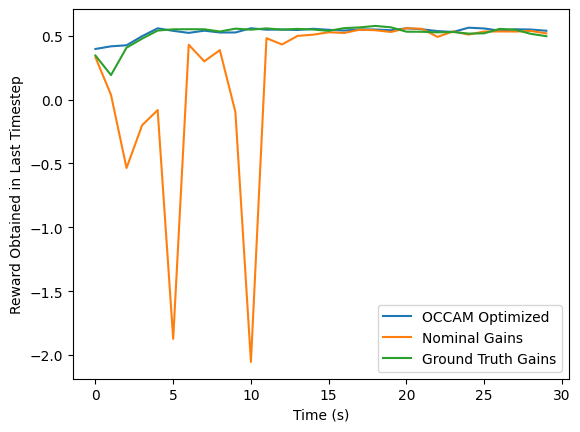

In [219]:
# full_traj_nom_np = np.array(full_traj_nom)
# plt.plot(np.abs(full_traj_nom_np[:,1]))
tsteps = np.arange(num_trials) * ep_length_s
plt.figure()
plt.plot(tsteps, np.mean(actual_rwds, axis=0))
plt.plot(tsteps, np.mean(actual_rwds_nom, axis=0))
plt.plot(tsteps, np.mean(actual_rwds_gt, axis=0))
plt.legend(["OCCAM Optimized", "Nominal Gains", "Ground Truth Gains"])
plt.xlabel("Time (s)")
plt.ylabel("Reward Obtained in Last Timestep")